# Exploraion de données : Détection de fake news

## Imports

In [181]:
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from nltk.stem.porter import PorterStemmer
from nltk.tokenize import WhitespaceTokenizer 
import string
from nltk import word_tokenize
from nltk.corpus import stopwords
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

## Extraction des données 

Dans cette partie on créera le data_frame qui nous permettra d'analyser les features et constituera les données d'aprenditssage pour la detection de fake news

In [182]:
BF_real_df = pd.read_csv('./Data/BuzzFeed_real_news_content.csv')

In [183]:
BF_fake_df = pd.read_csv('./Data/BuzzFeed_fake_news_content.csv')

In [184]:
#On ajoute le dataframe des fake news à la suite des real news
News_df = pd.concat([BF_real_df,BF_fake_df],ignore_index=True)

In [185]:
News_df.shape

(182, 12)

In [186]:
News_df

,id,title,text,url,top_img,authors,source,publish_date,movies,images,canonical_link,meta_data
0,Real_1-Webpage,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com/36942/another-terrorist...,http://eaglerising.com/wp-content/uploads/2016...,"View All Posts,Leonora Cravotta",http://eaglerising.com,{'$date': 1474528230000},NaN,http://constitution.com/wp-content/uploads/201...,http://eaglerising.com/36942/another-terrorist...,"{""description"": ""\u201cWe believe at this poin..."
1,Real_10-Webpage,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws/2d4lNn9,http://a.abcnews.com/images/Politics/AP_donald...,"More Candace,Adam Kelsey,Abc News,More Adam",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/donald-trump-dr...,"{""fb_title"": ""Trump: Drugs a 'Very, Very Big F..."
2,Real_11-Webpage,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com/barack-obama/obama-un...,http://rightwingnews.com/wp-content/uploads/20...,Cassy Fiano,http://rightwingnews.com,{'$date': 1474476044000},https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,http://rightwingnews.com/barack-obama/obama-un...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
3,Real_12-Webpage,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co/2de2qs0,http://static.politico.com/e9/11/6144cdc24e319...,"Jack Shafer,Erick Trickey,Zachary Karabell",http://politi.co,{'$date': 1474974420000},NaN,https://static.politico.com/dims4/default/8a1c...,http://www.politico.com/magazine/story/2016/09...,"{""description"": ""He sees it as zero-sum. She b..."
4,Real_13-Webpage,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws/2dh2NFs,http://a.abcnews.com/images/US/AP_Obama_BM_201...,"John Parkinson,More John,Abc News,More Alexander",http://abcn.ws,NaN,NaN,http://www.googleadservices.com/pagead/convers...,http://abcnews.go.com/Politics/president-obama...,"{""fb_title"": ""President Obama Vetoes 9/11 Vict..."
...,...,...,...,...,...,...,...,...,...,...,...,...
177,Fake_88-Webpage,Hillary’s TOP Donor Country Just Auctioned Off...,Hillary’s TOP Donor Country Just Auctioned Off...,http://rightwingnews.com/hillary-clinton-2/hil...,http://rightwingnews.com/wp-content/uploads/20...,Terresa Monroe-hamilton,http://rightwingnews.com,{'$date': 1474912025000},NaN,http://1.gravatar.com/avatar/d35b77ff6c3900715...,http://rightwingnews.com/hillary-clinton-2/hil...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
178,Fake_89-Webpage,Cavuto Just Exposed Lester Holt's Lies During ...,Advertisement - story continues below\n\nThe f...,http://conservativetribune.com/lester-holt-lie...,http://conservativetribune.com/wp-content/uplo...,"Martin Lioll,John Falkenberg,Ben Marquis,Kimbe...",http://conservativetribune.com,{'$date': 1474934400000},https://www.youtube.com/embed/ThwaDSaoGU8?feat...,http://conservativetribune.com/wp-content/uplo...,http://conservativetribune.com/lester-holt-lie...,"{""description"": ""People are already calling th..."
179,Fake_9-Webpage,"The AP, In 2004, Said Your Boy Obama Was BORN ...",Well THAT’S Weird. If the Birther movement is ...,http://clashdaily.com/2016/09/dear-cnn-ap-2004...,http://clashdaily.com/wp-content/uploads/2016/...,"Rich Witmer,Doug Giles",http://clashdaily.com,{'$date': 1474207108000},NaN,http://clashdaily.wpengine.netdna-cdn.com/wp-c...,http://clashdaily.com/2016/09/dear-cnn-ap-2004...,"{""googlebot"": ""noimageindex"", ""og"": {""site_nam..."
180,Fake_90-Webpage,People Noticed Something Odd About Hillary's O...,\n\nThere’s a lot to be discussed about last n...,http://www.thepoliticalinsider.com/first-presi...,http://assets.t

In [187]:
#Création d'une colonnes représentant notre cible (Real or Fake)
News_df["news_type"] = News_df["id"].apply(lambda x : x.split('_')[0])

In [188]:
News_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 182 entries, 0 to 181
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   id              182 non-null    object
 1   title           182 non-null    object
 2   text            182 non-null    object
 3   url             174 non-null    object
 4   top_img         172 non-null    object
 5   authors         141 non-null    object
 6   source          174 non-null    object
 7   publish_date    133 non-null    object
 8   movies          25 non-null     object
 9   images          172 non-null    object
 10  canonical_link  170 non-null    object
 11  meta_data       182 non-null    object
 12  news_type       182 non-null    object
dtypes: object(13)
memory usage: 18.6+ KB


In [189]:
#On garde que les colonnes qui nous interessent 
New_df_clean = News_df.drop(['id','url', 'top_img','authors','publish_date','canonical_link','meta_data'],axis=1)

In [190]:
New_df_clean

,title,text,source,movies,images,news_type
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,NaN,http://constitution.com/wp-content/uploads/201...,Real
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,NaN,http://www.googleadservices.com/pagead/convers...,Real
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com,https://www.youtube.com/embed/ji6pl5Vwrvk,http://rightwingnews.com/wp-content/uploads/20...,Real
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co,NaN,https://static.politico.com/dims4/default/8a1c...,Real
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws,NaN,http://www.googleadservices.com/pagead/convers...,Real
...,...,...,...,...,...,...
177,Hillary’s TOP Donor Country Just Auctioned Off...,Hillary’s TOP Donor Country Just Auctioned Off...,http://rightwingnews.com,NaN,http://1.gravatar.com/avatar/d35b77ff6c3900715...,Fake
178,Cavuto Just Exposed Lester Holt's Lies During ...,Advertisement - story continues below\n\nThe f...,http://conservativetribune.com,https://www.youtube.com/embed/ThwaDSaoGU8?feat...,http://conservativetribune.com/wp-content/uplo...,Fake
179,"The AP, In 2004, Said Your Boy Obama Was BORN ...",Well THAT’S Weird. If the Birther movement is ...,http://clashdaily.com,NaN,http://clashdaily.wpengine.netdna-cdn.com/wp-c...,Fake
180,People Noticed Something Odd About Hillary's O...,\n\nThere’s a lot to be discussed about last n...,http://www.thepoliticalinsider.com,NaN,http://1.gravatar.com/avatar/71be986d321b3d520...,Fake


In [191]:
# Creation des colonnes aves  1 si présence de video/image, 0 sinon
New_df_clean['Has_movie']=New_df_clean['movies'].apply(lambda x: 0 if str(x)=='nan' else 1)
New_df_clean['Has_images']=New_df_clean['images'].apply(lambda x: 0 if str(x)=='nan' else 1)
New_df_clean = New_df_clean.drop(["movies","images"],axis=1)

In [192]:
#On vérifie s'il reste des valeurs vides
New_df_clean.isnull().sum()

title         0
text          0
source        8
news_type     0
Has_movie     0
Has_images    0
dtype: int64

In [193]:
New_df_clean.shape

(182, 6)

In [194]:
#Supression des lignes avec des valeurs vides
New_df_clean = New_df_clean.dropna()

In [195]:
New_df_clean.shape

(174, 6)

In [196]:
New_df_clean.isnull().sum()

title         0
text          0
source        0
news_type     0
Has_movie     0
Has_images    0
dtype: int64

In [197]:
New_df_clean.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 174 entries, 0 to 181
Data columns (total 6 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   title       174 non-null    object
 1   text        174 non-null    object
 2   source      174 non-null    object
 3   news_type   174 non-null    object
 4   Has_movie   174 non-null    int64 
 5   Has_images  174 non-null    int64 
dtypes: int64(2), object(4)
memory usage: 9.5+ KB


In [198]:
New_df_clean

,title,text,source,news_type,Has_movie,Has_images
0,Another Terrorist Attack in NYC…Why Are we STI...,"On Saturday, September 17 at 8:30 pm EST, an e...",http://eaglerising.com,Real,0,1
1,"Donald Trump: Drugs a 'Very, Very Big Factor' ...",Less than a day after protests over the police...,http://abcn.ws,Real,0,1
2,"Obama To UN: ‘Giving Up Liberty, Enhances Secu...","Obama To UN: ‘Giving Up Liberty, Enhances Secu...",http://rightwingnews.com,Real,1,1
3,Trump vs. Clinton: A Fundamental Clash over Ho...,Getty Images Wealth Of Nations Trump vs. Clint...,http://politi.co,Real,0,1
4,"President Obama Vetoes 9/11 Victims Bill, Sett...",President Obama today vetoed a bill that would...,http://abcn.ws,Real,0,1
...,...,...,...,...,...,...
177,Hillary’s TOP Donor Country Just Auctioned Off...,Hillary’s TOP Donor Country Just Auctioned Off...,http://rightwingnews.com,Fake,0,1
178,Cavuto Just Exposed Lester Holt's Lies During ...,Advertisement - story continues below\n\nThe f...,http://conservativetribune.com,Fake,1,1
179,"The AP, In 2004, Said Your Boy Obama Was BORN ...",Well THAT’S Weird. If the Birther movement is ...,http://clashdaily.com,Fake,0,1
180,People Noticed Something Odd About Hillary's O...,\n\nThere’s a lot to be discussed about last n...,http://www.thepoliticalinsider.com,Fake,0,1


## Analyse de données

1. Etude des sources des informations

In [199]:
#liste des sources ayant publié des Real news triée
real_sources = New_df_clean[New_df_clean['news_type']=='Real']['source'].value_counts().sort_values(ascending=False).index

Text(0.5, 1.0, 'Real News sources count')

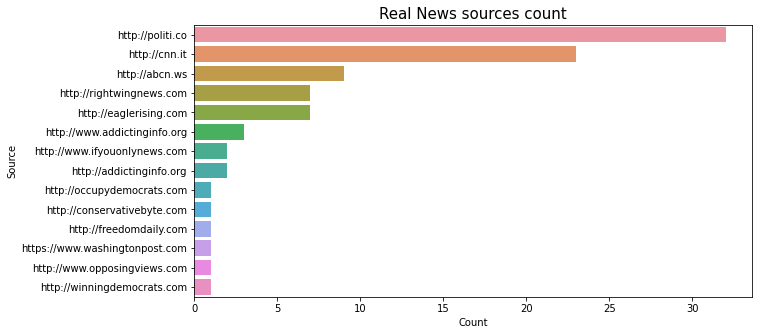

In [200]:
plt.close("all")
plt.figure(figsize=(10,5))
sns.countplot(y='source', data=New_df_clean[New_df_clean['news_type']=='Real'],order=real_sources)
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Real News sources count',fontsize=15)

Les sources ayant publié le plus de real news sont politi.co puis cnn.it

In [201]:
#liste des sources ayant publié des Real news triée
fake_sources = New_df_clean[New_df_clean['news_type']=='Fake']['source'].value_counts().sort_values(ascending=False).index

Text(0.5, 1.0, 'Fake News sources count')

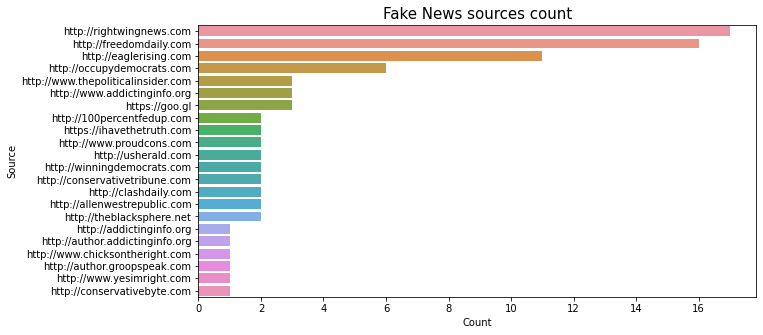

In [202]:
plt.close("all")
plt.figure(figsize=(10,5))
sns.countplot(y='source', data=New_df_clean[New_df_clean['news_type']=='Fake'],order=fake_sources)
plt.xlabel('Count')
plt.ylabel('Source')
plt.title('Fake News sources count',fontsize=15)

Les deux sources les plus importantes de Fake news sont roghtwingsnews.com et freedomdaily.com

In [203]:
sources = New_df_clean["source"].unique()

In [204]:
#liste des sources publiant des Fake et des Real News
common_sources = []
for s in sources:
    if s in real_sources and s in fake_sources :
        common_sources.append(s)
        
common_sources

['http://eaglerising.com',
 'http://rightwingnews.com',
 'http://occupydemocrats.com',
 'http://conservativebyte.com',
 'http://freedomdaily.com',
 'http://www.addictinginfo.org',
 'http://addictinginfo.org',
 'http://winningdemocrats.com']

In [205]:
#Création d'une colonne contenant la source si dans la liste précédente 0 sinon
New_df_clean['common_sources']=New_df_clean['source'].apply(lambda x: x if x in common_sources else 0)
#Selection des sources communes
common_df = New_df_clean[New_df_clean['common_sources']!=0]

Text(0.5, 1.0, 'Common Sources count')

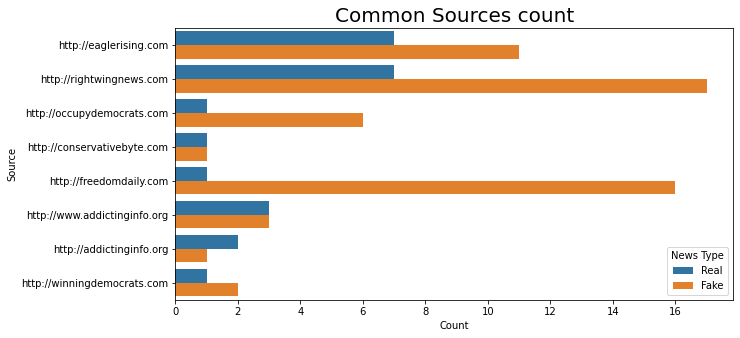

In [206]:
plt.close("all")
plt.figure(figsize=(10,5))
sns.countplot(y='common_sources',data=common_df,hue='news_type')
plt.xlabel('Count')
plt.ylabel('Source')
plt.legend( title='News Type')
plt.title('Common Sources count',fontsize=20)


2. Etude de la présence de medias dans l'article 

Text(0.5, 1.0, 'Number of news with or without movies by type')

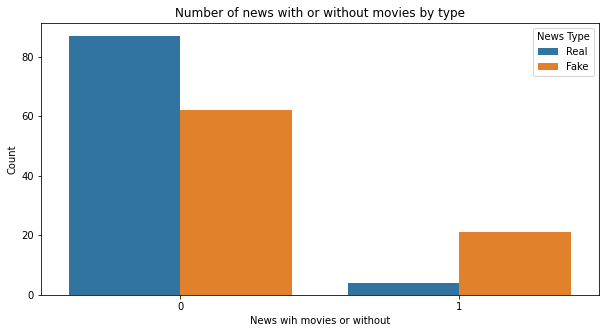

In [207]:
plt.close("all")
plt.figure(figsize=(10,5))
sns.countplot(x='Has_movie', data=New_df_clean, hue='news_type')
plt.xlabel('News wih movies or without')
plt.ylabel('Count')
plt.legend(title='News Type')
plt.title('Number of news with or without movies by type')

La plupart des News ne contiennent pas de vidéo

Text(0.5, 1.0, 'Number of news with or without images by type')

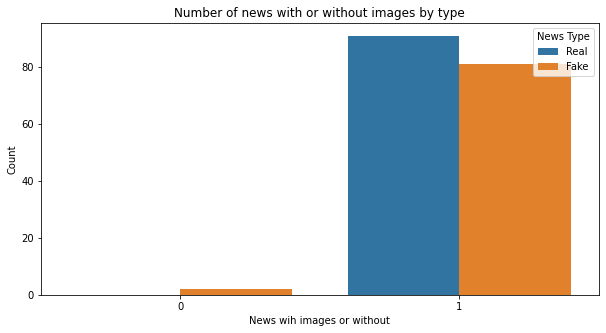

In [208]:
plt.close("all")
plt.figure(figsize=(10,5))
sns.countplot(x='Has_images', data=New_df_clean, hue='news_type')
plt.xlabel('News wih images or without')
plt.ylabel('Count')
plt.legend(title='News Type')
plt.title('Number of news with or without images by type')

La plupart des News contienent des images 

## Prerocessing

On définie une fonction pour préparer les données textuelles en suivant les étapes suivantes :


  Convertion du texte en minuscules

  Retrait des chiffres présents dans le texte

  Retrait des ponctuations

  Rerait des caracteres spéciaux

  Retrait des mots de liaison

  Reduction des mots à leur racine

  Retrait des espaces


In [209]:
#Fonction de preprocessing du text
def text_preprocess(str0):
    ps=PorterStemmer()
    wst= WhitespaceTokenizer() 
    str0 = str0.lower()
    str1 = ''.join([i for i in str0 if not i.isdigit()])
    str2 = str1.translate(str.maketrans('', '', string.punctuation))
    str3 = ''.join(e for e in str2 if e.isalnum() or e==' ')
    word_list = str3.split()
    filtered_words = [word for word in word_list if word not in stopwords.words('english')]
    str4 = ' '.join(filtered_words)
    wordlist = word_tokenize(str4)
    stem = [ps.stem(a) for a in wordlist]
    str5 = ' '.join(stem)
    str6 = wst.tokenize(str5)
    return str6
    

In [210]:
#Pretraitement de colonne source 
New_df_clean['source'] = New_df_clean['source'].apply(text_preprocess)
New_df_clean['source'] = New_df_clean['source'].apply(lambda x : x[0])

In [211]:
#On fusionne les diférents colonnes
New_df_clean['title_text_source']=New_df_clean['title']+': ' +New_df_clean['text']+': ' +New_df_clean['source']

In [212]:
X1=New_df_clean['title_text_source']
y1=New_df_clean['news_type']

In [213]:
X1_train, X1_test, y1_train, y1_test = train_test_split(X1, y1, test_size=0.25)

In [214]:
pp=Pipeline([('bow',CountVectorizer(analyzer=text_preprocess)),('tfidf',TfidfTransformer()),('classifier',KNeighborsClassifier())])

In [215]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_preprocess at 0x0000024E60648790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', KNeighborsClassifier())])

In [216]:
predict_KNN=pp.predict(X1_test)

In [217]:
print(classification_report(y1_test, predict_KNN))

              precision    recall  f1-score   support

        Fake       0.83      0.62      0.71        24
        Real       0.65      0.85      0.74        20

    accuracy                           0.73        44
   macro avg       0.74      0.74      0.73        44
weighted avg       0.75      0.73      0.73        44



*
*
*
*
**




In [218]:
pp=Pipeline([('bow',CountVectorizer(analyzer=text_preprocess)),('tfidf',TfidfTransformer()),('classifier',DecisionTreeClassifier())])

In [219]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_preprocess at 0x0000024E60648790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', DecisionTreeClassifier())])

In [220]:
predict_Dectree=pp.predict(X1_test)

In [221]:
print(classification_report(y1_test, predict_Dectree))

              precision    recall  f1-score   support

        Fake       0.59      0.54      0.57        24
        Real       0.50      0.55      0.52        20

    accuracy                           0.55        44
   macro avg       0.55      0.55      0.54        44
weighted avg       0.55      0.55      0.55        44



In [222]:
pp=Pipeline([('bow',CountVectorizer(analyzer=text_preprocess)),('tfidf',TfidfTransformer()),('classifier',MLPClassifier())])

In [223]:
pp.fit(X1_train,y1_train)

Pipeline(steps=[('bow',
                 CountVectorizer(analyzer=<function text_preprocess at 0x0000024E60648790>)),
                ('tfidf', TfidfTransformer()),
                ('classifier', MLPClassifier())])

In [224]:
predict_MLP=pp.predict(X1_test)

In [225]:
print(classification_report(y1_test, predict_MLP))

              precision    recall  f1-score   support

        Fake       0.86      0.75      0.80        24
        Real       0.74      0.85      0.79        20

    accuracy                           0.80        44
   macro avg       0.80      0.80      0.80        44
weighted avg       0.80      0.80      0.80        44

